In [48]:
import pandas as pd
from pyspark.sql.functions import (col, rand, udf, collect_set, collect_list, concat, array_distinct, flatten, when, length)
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, FloatType
from unidecode import unidecode
import re
from functools import reduce
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, GlobalMaxPooling1D, Layer, Masking, Lambda, Permute
import os
import pickle
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [2]:
#env: geoNames

In [3]:
catalog.list()

['df_input', 'df_output', 'geonames_latin_pairs', 'parameters']

In [4]:
geonames_pairs = catalog.load('geonames_latin_pairs')

[08/12/23 12:29:29] INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=147449;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=268822;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [5]:
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))

In [6]:

geonames_pairs.groupBy('language_1').count().orderBy('count').toPandas().tail(50)

,language_1,count
203,MK,10939
204,SD,10941
205,BD,11051
206,IL,11533
207,CZ,11808
208,AZ,12792
209,JO,12801
210,US,12893
211,AL,13844
212,LT,14028


# 1. POC with Spain and Mexico

In [7]:
geonames_pairs_es = geonames_pairs.filter(col('language_1').isin(['ES', 'MX']))

In [8]:
geonames_pairs_es.show()

+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+
|              name_1|              name_2|    id_1|    id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|
+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+
|              Atoyac|          Rio Atojac| 3532571| 3532572|     LATIN|     LATIN|        MX|        MX|false|   0.0|
|           La Cumbre|      Cerro Natiltón| 9624088| 9624363|     LATIN|     LATIN|        MX|        MX|false|   0.0|
|Salinas de El Cab...|        Cabo de Gata| 2518666| 2518667|     LATIN|     LATIN|        ES|        ES|false|   0.0|
|               Palma|            La Palma| 3525283| 3525287|     LATIN|     LATIN|        MX|        MX|false|   0.0|
|   Caserio La Parata|   Caserio la Paloma| 2515676| 2515678|     LATIN|     LATIN|        ES|        ES|false|   0.0|
|        Chichen Itza|         Chichen-Ica| 3530

# 2. Function to normalize names

Requirements:

* Transform to unicode characters (utf-8)
* remove whitespaces

In [9]:
def normalize_characters(text: str) -> str:
    
    if text is None:
        return ''

    strange_char_space = r"!#$%&()*+,./:;<=>?@[\]^_{|}~ºª®-"
    char_2_remove = "\"'^`"
    space_mask = "                                "
    punctuation_table = str.maketrans(strange_char_space, space_mask,
                                        char_2_remove)
    text = text.lower()
    text = text.strip()
    text = unidecode(text)
    text = text.translate(punctuation_table)
    text = re.sub(r' +', ' ', text)
    text = text.strip()
    text = text.lower()

    return text

In [10]:
udf_normalize_chars = udf(normalize_characters)

In [11]:
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))
                            

# 3. Function to generate vocabulary

In [12]:
def get_unique_characters(string: str) -> list:

    unique_characters = list(set(string))
    return unique_characters

udf_get_unique_characters = udf(get_unique_characters, ArrayType(StringType()))


def compute_max_word_len(string: str) -> int:
    return max([len(word) for word in string.split(' ')])

udf_compute_max_word_len = udf(compute_max_word_len)

def compute_token_count(string: str) -> int:
    return len([word for word in string.split(' ')])

udf_compute_token_count = udf(compute_token_count)

In [13]:
geonames_characters = geonames_normalized.withColumn('unique_characters_1', udf_get_unique_characters(col('name_1_normalized'))) \
                                        .withColumn('unique_characters_2', udf_get_unique_characters(col('name_2_normalized'))) \
                                        .withColumn('unique_characters', array_distinct(concat(col('unique_characters_1'), col('unique_characters_2')))) \
                                        .withColumn('max_word_len_1', udf_compute_max_word_len(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_word_len_2', udf_compute_max_word_len(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_1', udf_compute_token_count(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_token_num_2', udf_compute_token_count(col('name_2_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_1', length(col('name_1_normalized')).cast(FloatType())) \
                                        .withColumn('max_len_2', length(col('name_2_normalized')).cast(FloatType()))

In [14]:
geonames_characters.printSchema()

root
 |-- name_1: string (nullable = true)
 |-- name_2: string (nullable = true)
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- alphabet_1: string (nullable = true)
 |-- alphabet_2: string (nullable = true)
 |-- language_1: string (nullable = true)
 |-- language_2: string (nullable = true)
 |-- match: string (nullable = true)
 |-- target: float (nullable = false)
 |-- name_1_normalized: string (nullable = true)
 |-- name_2_normalized: string (nullable = true)
 |-- unique_characters_1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- unique_characters_2: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- unique_characters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- max_word_len_1: float (nullable = true)
 |-- max_word_len_2: float (nullable = true)
 |-- max_token_num_1: float (nullable = true)
 |-- max_token_num_2: float (nullable = true)
 |-- max_len_1: float (nullabl

In [15]:
geonames_characters.show()

+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------------+---------------+---------+---------+
|              name_1|              name_2|    id_1|    id_2|alphabet_1|alphabet_2|language_1|language_2|match|target|   name_1_normalized|   name_2_normalized| unique_characters_1| unique_characters_2|   unique_characters|max_word_len_1|max_word_len_2|max_token_num_1|max_token_num_2|max_len_1|max_len_2|
+--------------------+--------------------+--------+--------+----------+----------+----------+----------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------------+---------------+---------+---------+
|              Atoyac|          Rio Atojac| 3532571| 3532572|     LATIN|     LATIN

In [16]:
geonames_char_list = geonames_characters.groupBy().agg(
    array_distinct(flatten(collect_set(col('unique_characters')))).alias('char_list'),
    F.max(col('max_word_len_1')).alias('max_len_1'),
    F.max(col('max_word_len_2')).alias('max_len_2'),
    F.max(col('max_token_num_2')).alias('max_num_2'),
    F.max(col('max_token_num_1')).alias('max_num_1'),
    F.max(col('max_len_1')).alias('max_len_1'),
    F.max(col('max_len_2')).alias('max_len_1')
)

In [17]:
geonames_char_list.show()

+--------------------+---------+---------+---------+---------+---------+---------+
|           char_list|max_len_1|max_len_2|max_num_2|max_num_1|max_len_1|max_len_1|
+--------------------+---------+---------+---------+---------+---------+---------+
|[n, h, o, r, a, d...|     27.0|     27.0|     18.0|     14.0|     96.0|    111.0|
+--------------------+---------+---------+---------+---------+---------+---------+



In [19]:
characters_list = geonames_char_list.rdd.map(lambda x: x.char_list).collect()[0]
sorted_char_list = sorted(characters_list)

# 4. One Hot encoder

In [20]:
char_to_index = {char: index for index, char in enumerate(sorted_char_list)}
index_to_char = {index: char for char, index in char_to_index.items()}
MAX_WORD_LENGTH = 16
MAX_TOKEN_NUMBER = 8
MAX_NAME_LEN = 100

In [21]:
char_to_index


{
    ' ': 0,
    '0': 1,
    '1': 2,
    '2': 3,
    '3': 4,
    '4': 5,
    '5': 6,
    '6': 7,
    '7': 8,
    '8': 9,
    '9': 10,
    'a': 11,
    'b': 12,
    'c': 13,
    'd': 14,
    'e': 15,
    'f': 16,
    'g': 17,
    'h': 18,
    'i': 19,
    'j': 20,
    'k': 21,
    'l': 22,
    'm': 23,
    'n': 24,
    'o': 25,
    'p': 26,
    'q': 27,
    'r': 28,
    's': 29,
    't': 30,
    'u': 31,
    'v': 32,
    'w': 33,
    'x': 34,
    'y': 35,
    'z': 36
}

In [22]:
def one_hot_encoder(string: str, char_to_index_dict: dict) -> np.array:

    vocabulary_size = len(char_to_index_dict.keys())
    vector = np.zeros(vocabulary_size)
    for char in string:
        vector[char_to_index[char]-1] = 1 
    return vector

def encode_name_list(iterable: iter, char_to_index_dict: dict) -> np.array:

    return np.array([one_hot_encoder(string, char_to_index_dict) for string in iterable])

def check_chars_OOV(string: str, char_to_index_dict: dict) -> bool:

    vocabulary = char_to_index_dict.keys()
    return all([char in vocabulary for char in string])

def name_matrix_encoder(string: iter, char_to_index_dict: dict, max_word_length:int, max_token_number:int) -> np.array :

    representation_matrix = np.zeros(shape=(max_token_number, max_word_length))
    for token_ind, token in enumerate(string.split(' ')):
        for char_ind, char in enumerate(token):
            try:
                representation_matrix[token_ind][char_ind] = char_to_index[char]
            except IndexError:
                continue
    return representation_matrix

def sparse_encoder(string: str, char_to_index_dict: dict, max_len: int) -> np.array:

    vector = np.zeros(max_len)
    for ind, char in enumerate(string):
        if ind>=max_len:
            break
        vector[ind] = char_to_index[char]
    return vector

def encode_sparsed_list(iterable: iter, char_to_index_dict: dict, max_len: int) -> np.array:
    
    return np.array([sparse_encoder(string, char_to_index_dict, max_len) for string in iterable])

In [23]:
name_pairs = geonames_characters.select('name_1_normalized', 'name_2_normalized').toPandas().values

In [24]:
names_encoded_1 = np.array([name_matrix_encoder(name,
                                                char_to_index_dict=char_to_index,
                                                max_word_length=MAX_WORD_LENGTH,
                                                max_token_number=MAX_TOKEN_NUMBER
                                               ) for name in name_pairs[:, 0]], dtype=object)

names_encoded_2 = np.array([name_matrix_encoder(name,
                                                char_to_index_dict=char_to_index,
                                                max_word_length=MAX_WORD_LENGTH,
                                                max_token_number=MAX_TOKEN_NUMBER
                                               ) for name in name_pairs[:, 1]], dtype=object)

In [25]:
string1, string2 = 'dpe', 'daniel perez efremova'
strig1_matrix = name_matrix_encoder(string1, 
                                    char_to_index_dict=char_to_index,
                                    max_word_length=MAX_WORD_LENGTH,
                                    max_token_number=MAX_TOKEN_NUMBER)
strig2_matrix = name_matrix_encoder(string2, 
                                    char_to_index_dict=char_to_index,
                                    max_word_length=MAX_WORD_LENGTH,
                                    max_token_number=MAX_TOKEN_NUMBER)

In [25]:
def show_field(field1,field2):

    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1,cmap=plt.cm.hot, vmin = _min, vmax = _max)
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2,cmap=plt.cm.hot, vmin = _min, vmax = _max)
    ax2.autoscale(False)
    plt.show()

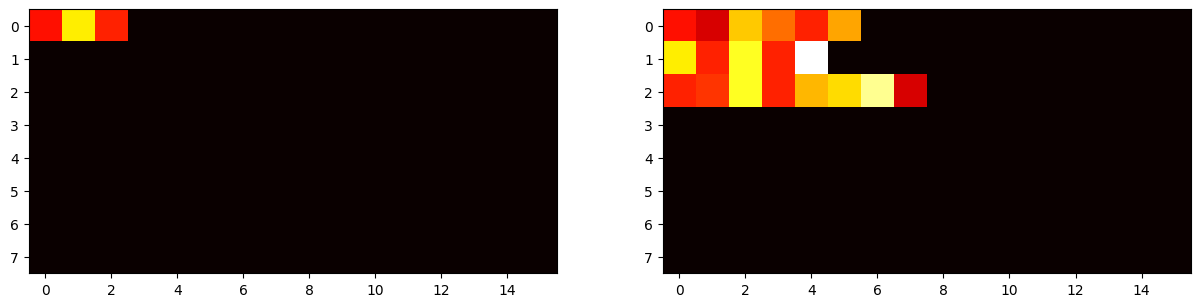

In [29]:
show_field(strig1_matrix, strig2_matrix)

# 5.1. Create a model class for char2vec embedding (One hot encoder - Siamese LSTM - Cosine similarity)

In [4]:
class poiNames_C2V:
    
    def __init__(self, embedding_size:int, char_to_index:dict):

        self.char_to_index = char_to_index
        self.index_to_char = {char_to_index[char]: char for char in char_to_index}
        self.input_size = MAX_NAME_LEN
        self.embedding_size = embedding_size

        lstm_input = tf.keras.layers.Input(shape=(self.input_size, 1,), name='lstm_input')
        x = tf.keras.layers.Masking(mask_value=0)(lstm_input)
        x = Bidirectional(tf.keras.layers.LSTM(self.embedding_size, return_sequences=True, name='lstm_1'))(x)
        x = Bidirectional(tf.keras.layers.LSTM(self.embedding_size, name='lstm_2'))(x)
        self.embedding_model = tf.keras.models.Model(inputs=[lstm_input], outputs=x)

        left_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1), name='left_branch_input')
        right_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1),name='right_branch_input')

        left_branch_embedding = self.embedding_model(left_branch_input)
        right_branch_embedding = self.embedding_model(right_branch_input)

        concat_layer = tf.keras.layers.Concatenate(axis=1)([left_branch_embedding, right_branch_embedding])
        product_layer = tf.keras.layers.Multiply()([left_branch_embedding, right_branch_embedding])
        difference_layer = tf.keras.layers.Subtract()([left_branch_embedding, right_branch_embedding])

         
        representation_layer = tf.keras.layers.Concatenate(axis=1)([concat_layer, product_layer, difference_layer])
        
        x = tf.keras.layers.Dropout(0.3)(representation_layer)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
                
        # x = tf.keras.layers.Dot(axes=1, normalize=True)([left_branch_embedding, right_branch_embedding]) # cosine similarity
        # model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        self.model = tf.keras.models.Model(inputs=[left_branch_input, right_branch_input], outputs=model_output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                              tf.keras.metrics.Precision(),
                                                              tf.keras.metrics.Recall()])
        
    def fit(
        self, name_pairs, target, max_epochs:int, patience:int, validation_split:float, batch_size:int, callbacks: iter):

        print(f'Encoding names... ({2*len(name_pairs)})')
        # X1 = encode_name_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index)
        # X2 = encode_name_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index)

        X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X2 = encode_sparsed_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        
        X1 = np.expand_dims(X1, axis=-1)
        X2 = np.expand_dims(X2, axis=-1)
        
        X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)
        X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)
        
        self.model.fit((X1_pad, X2_pad), target,verbose=1,
                    batch_size=batch_size, epochs=max_epochs,
                    validation_split=validation_split,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)] + callbacks)


    def save_model(self, path_to_model):
        '''
        Saves trained model to directory.
    
        :param path_to_model: str, path to save model.
        '''
    
        if not os.path.exists(path_to_model):
            os.makedirs(path_to_model)
        
        self.embedding_model.save_weights(path_to_model + '/weights.h5')
    
        with open(path_to_model + '/model.pkl', 'wb') as f:
            pickle.dump([self.embedding_size, self.char_to_index], f, protocol=2)


    def load_model(self, path):
        '''
        Loads trained model.
    
        :param path: loads model from `path`.
    
        :return c2v_model: Chars2Vec object, trained model.
        '''
        path_to_model = path
    
        with open(path_to_model + '/model.pkl', 'rb') as f:
            structure = pickle.load(f)
            embedding_size, char_to_index = structure[0], structure[1]
    
        model = poiNames_C2V(embedding_size=embedding_size, char_to_index=char_to_index)
        model.embedding_model.load_weights(path_to_model + '/weights.h5')
        model.embedding_model.compile(optimizer='adam', loss='mae')
    
        return model


    def vectorize(self, iterable: iter) -> np.array:
        
        X = encode_name_list(iterable,char_to_index_dict=self.char_to_index)
        X = np.expand_dims(X, axis=-1)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(X)

        return X_pad, self.embedding_model(X_pad)
        

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱   1 class poiNames_C2V:                                                                        │
│     2 │                                                                                          │
│     3 │   def __init__(self, embedding_size:int, char_to_index:dict):                            │
│     4                                                                                            │
│                                                                                                  │
│ in poiNames_C2V:101                                                                              │
│                                                                                                  │
│    98 │   │   return model                                                                       │
│    99 │                                                                                          │
│   100 │                                                                                          │
│ ❱ 101 │   def vectorize(self, iterable: iter) -> np.array:                                       │
│   102 │   │                                                                                      │
│   103 │   │   X = encode_name_list(iterable,char_to_index_dict=self.char_to_index)               │
│   104 │   │   X = np.expand_dims(X, axis=-1)                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'np' is not defined

## Data Preparation

In [64]:
name_pairs = geonames_characters.select('name_1_normalized', 'name_2_normalized').toPandas().values

In [65]:
target = geonames_characters.select(col('target')).toPandas().astype(float).values

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(name_pairs, target, test_size=0.1, random_state=0)

len(X_train), len(X_test)

(49178, 5465)

In [67]:
poi_c2v = poiNames_C2V(150, char_to_index)

In [68]:
from keras.callbacks import History
history = History()

poi_c2v.fit(
    name_pairs=X_train,
    target=y_train,
    validation_split=0.1,
    max_epochs=10000,
    patience=10,
    batch_size=128,
    callbacks=[history])

Encoding names... (98356)
Epoch 1/10000
346/346 [==============================] - 284s 776ms/step - loss: 0.6800 - accuracy: 0.5463 - precision_2: 0.5428 - recall_2: 0.5693 - val_loss: 0.5997 - val_accuracy: 0.7011 - val_precision_2: 0.6900 - val_recall_2: 0.7123
Epoch 2/10000
346/346 [==============================] - 268s 774ms/step - loss: 0.5721 - accuracy: 0.7262 - precision_2: 0.7591 - recall_2: 0.6603 - val_loss: 0.5557 - val_accuracy: 0.7403 - val_precision_2: 0.7750 - val_recall_2: 0.6652
Epoch 3/10000
346/346 [==============================] - 270s 781ms/step - loss: 0.5517 - accuracy: 0.7413 - precision_2: 0.7970 - recall_2: 0.6454 - val_loss: 0.5427 - val_accuracy: 0.7495 - val_precision_2: 0.8152 - val_recall_2: 0.6346
Epoch 4/10000
346/346 [==============================] - 269s 779ms/step - loss: 0.5432 - accuracy: 0.7476 - precision_2: 0.8121 - recall_2: 0.6423 - val_loss: 0.5450 - val_accuracy: 0.7428 - val_precision_2: 0.8072 - val_recall_2: 0.6267
Epoch 5/10000
346/

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│    1 from keras.callbacks import History                                                         │
│    2 history = History()                                                                         │
│    3                                                                                             │
│ ❱  4 poi_c2v.fit(                                                                                │
│    5 │   name_pairs=X_train,                                                                     │
│    6 │   target=y_train,                                                                         │
│    7 │   validation_split=0.1,                                                                   │
│                                                                                                  │
│ in fit:56                                                                                        │
│                                                                                                  │
│    53 │   │   X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)                         │
│    54 │   │   X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)                         │
│    55 │   │                                                                                      │
│ ❱  56 │   │   self.model.fit((X1_pad, X2_pad), target,verbose=1,                                 │
│    57 │   │   │   │   │   batch_size=batch_size, epochs=max_epochs,                              │
│    58 │   │   │   │   │   validation_split=validation_split,                                     │
│    59 │   │   │   │   │   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', pati   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py:65 in error_handler        │
│                                                                                                  │
│    62 │   │                                                                                      │
│    63 │   │   filtered_tb = None                                                                 │
│    64 │   │   try:                                                                               │
│ ❱  65 │   │   │   return fn(*args, **kwargs)                                                     │
│    66 │   │   except Exception as e:                                                             │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1650 in fit                      │
│                                                                                                  │
│   1647 │   │   │   │   │   │   │   _r=1,                                                         │
│   1648 │   │   │   │   │   │   ):                                                                │
│   1649 │   │   │   │   │   │   │   callbacks.on_train_batch_begin(step)                          │
│ ❱ 1650 │   │   │   │   │   │   │   tmp_logs = self.train_function(iterator)                      │
│   1651 │   │   │   │   │   │   │   if data_handler.should_sync:                                  │
│   1652 │   │   │   │   │   │   │   │   context.async_wait()                                      │
│   1653 │   │   │   │   │   │   │   # No error, now safe to 

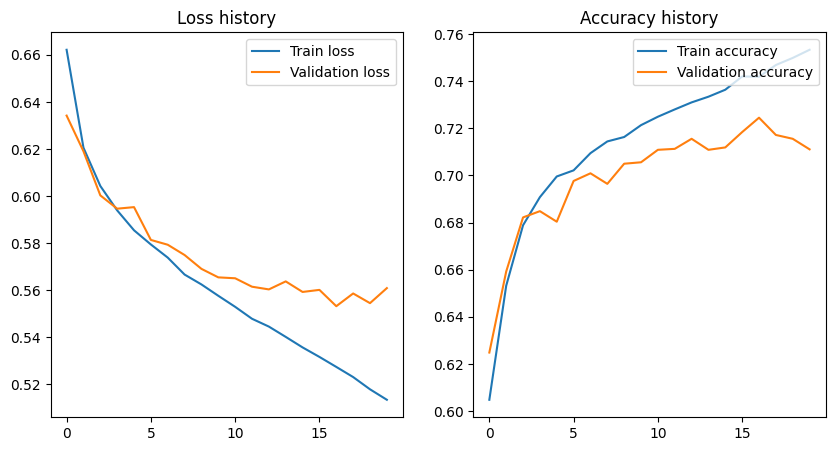

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

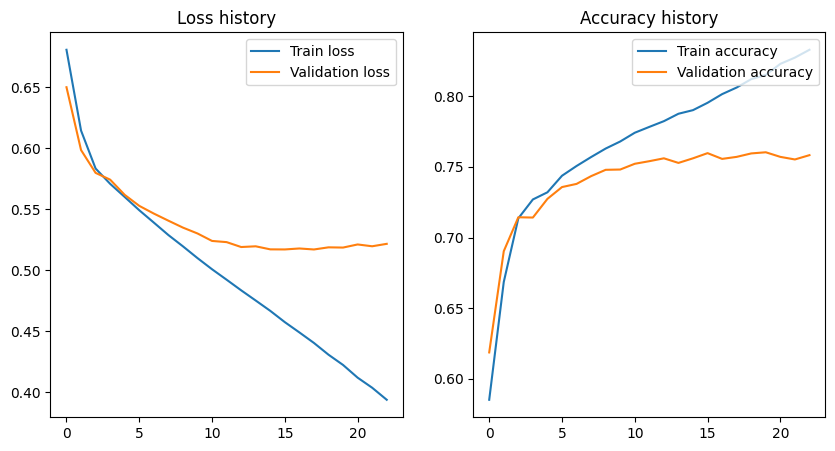

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

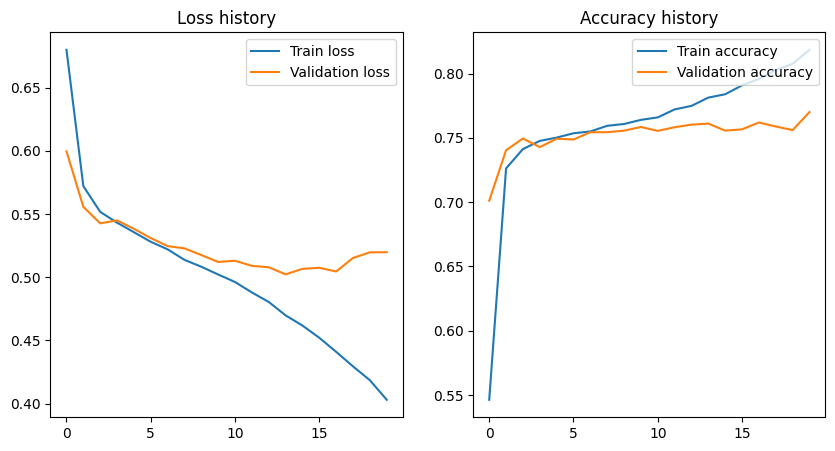

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

In [2]:
poi_c2v.save_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-Deep-geonames-spanish/')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 poi_c2v.save_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-Deep-geo     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'poi_c2v' is not defined

In [3]:
poi_c2v.load_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-geonames-spanish/')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 poi_c2v.load_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-geonames     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'poi_c2v' is not defined

In [1]:
poi_c2v.model.summary()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 poi_c2v.model.summary()                                                                      │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'poi_c2v' is not defined

In [71]:
X_test_1 = encode_sparsed_list(X_test[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_test_2 = encode_sparsed_list(X_test[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

# X_train_1, X_train_1_embed = poi_c2v.vectorize(X_train[:, 0])
# X_train_2, X_train_2_embed = poi_c2v.vectorize(X_train[:, 1])

In [72]:
test_predictions = poi_c2v.model.predict((X_test_1, X_test_2))
# train_predictions = poi_c2v.model.predict((X_train_1, X_train_2))

171/171 [==============================] - 24s 112ms/step



(
    array([ 850.,  648.,  532.,  423.,  350.,  313.,  341.,  381.,  494.,
       1133.]),
    array([2.11265215e-04, 1.00089163e-01, 1.99967057e-01, 2.99844950e-01,
       3.99722844e-01, 4.99600738e-01, 5.99478662e-01, 6.99356556e-01,
       7.99234450e-01, 8.99112344e-01, 9.98990238e-01]),
    <BarContainer object of 10 artists>
)

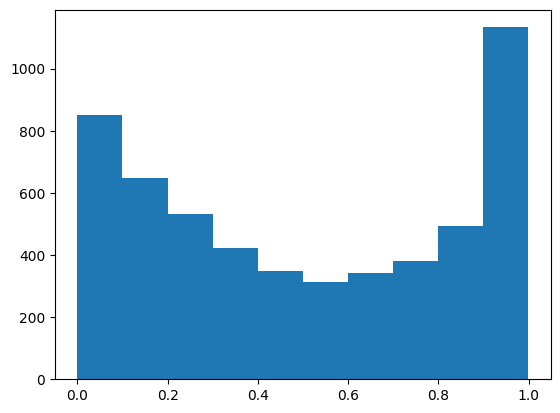

In [73]:
plt.hist(test_predictions)

In [88]:
pd.crosstab((y_test>=.75).flatten(), (test_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,2070,636
True,733,2026


In [89]:
print(classification_report((y_test>=.5).flatten(), (test_predictions>=.5).flatten()))

              precision    recall  f1-score   support

       False       0.74      0.76      0.75      2706
        True       0.76      0.73      0.75      2759

    accuracy                           0.75      5465
   macro avg       0.75      0.75      0.75      5465
weighted avg       0.75      0.75      0.75      5465



In [90]:
from fuzzywuzzy import fuzz

In [94]:
token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_test])>.75

In [95]:
pd.crosstab((y_test>=.5).flatten(), token_set_predictions)

col_0,False,True
row_0,,
False,2303,403
True,724,2035


In [96]:
print(classification_report((y_test>=.75).flatten(), token_set_predictions))

              precision    recall  f1-score   support

       False       0.76      0.85      0.80      2706
        True       0.83      0.74      0.78      2759

    accuracy                           0.79      5465
   macro avg       0.80      0.79      0.79      5465
weighted avg       0.80      0.79      0.79      5465



In [97]:
results = pd.DataFrame(X_test)
results['prediction'] = test_predictions>=.5
results['prediction'] = results['prediction'].astype(float)
results['label'] = y_test
results.columns = ['name_1', 'name_2', 'prediction', 'label']
results['error'] = results['prediction'] != results['label']

In [98]:
results.to_csv('results.csv', index=False)

# 6. Prediciton

In [99]:
standard_1 = np.array(['dave smith', 'international business machine corp', 'bill gates', 'william h gates', 'mary miller', 'mary', 'ibm inc', 'ibm inc', 'dave smith', 'royal free hospital', 'royal free hospital emergency room', 'royal free hospital school of medicine'])
standard_2 = np.array(['david smith', 'ibm', 'william gates', 'william a gates', 'mark miller', 'mark', 'ibm corp', 'ibs inc', 'smith dave', 'royal free hospital emergency room', 'royal free hospital immunology', 'royal free hospital immunology'])
standard_target = np.array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
token_set_ratio = [fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in list(zip(standard_1, standard_2))]

In [100]:
standard_1_vectorized = encode_sparsed_list(standard_1,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
standard_2_vectorized = encode_sparsed_list(standard_2,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [101]:
standard_predictions = poi_c2v.model.predict((standard_1_vectorized, standard_2_vectorized))

1/1 [==============================] - 0s 117ms/step


In [102]:
pd.DataFrame(list(zip(standard_1, standard_2, standard_target, standard_predictions, token_set_ratio)))

,0,1,2,3,4
0,dave smith,david smith,1,[0.9574919],0.86
1,international business machine corp,ibm,1,[0.17393866],0.11
2,bill gates,william gates,1,[0.9042522],0.78
3,william h gates,william a gates,0,[0.9814604],0.93
4,mary miller,mark miller,0,[0.972018],0.91
5,mary,mark,0,[0.8049448],0.75
6,ibm inc,ibm corp,1,[0.64314485],0.67
7,ibm inc,ibs inc,0,[0.85294044],0.86
8,dave smith,smith dave,1,[0.09877295],1.00
9,royal free hospital,royal free hospital emergency room,0,[0.088789076],1.00


# 5.2. Create a model class (Sparse encoder - Siamese ConvNet)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')